# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import nltk

import itertools

# Load Data

In [2]:
df = pd.read_csv('../data/train.tsv', sep='\t')
train_data = df.to_records(index=False)
train_data[:3]

rec.array([('nano composites were prepared by dispersing barium titanate  BT  and/or oMMT clay particles in epoxy resin.', 'action'),
           ('In this process, the magnetic stirring lasted 2 h at room temperature.', 'action'),
           ('This coating heating cycle was repeated several times to achieve the desired film thickness', 'action')],
          dtype=[('text', 'O'), ('label', 'O')])

## Preprocess (sentence level)

In [3]:
from sentence_level_preprocess import *

In [4]:
# remove line breaks (e.g. "elec- tron" -> "electron")
train_data = [(rm_linebreaks(t), l) for t, l in train_data]

# lower case
train_data = [(t.lower(), l) for t, l in train_data]

# unify expressions for temperature (e.g. '° c' -> '<temp>')
train_data = [(c2temp_2(t), l) for t, l in train_data]

## Tokenize

In [5]:
train_data = [(nltk.tokenize.word_tokenize(t), l) for t, l in train_data]

## Preprocess (word level)

In [6]:
from word_level_preprocess import *

In [7]:
# recognize integer as '<int>' (e.g. '60' -> '<int>')
train_data = [([put_int_together(w) for w in t], l) for t, l in train_data]

# recognize decimal as '<dec>' (e.g. '0.5' -> '<dec>')
train_data = [([put_decimal_together(w) for w in t], l) for t, l in train_data]

# recognize ratioas '<ratio>' (e.g. '1:1' -> '<ratio>')
train_data = [([put_ratio_together(w) for w in t], l) for t, l in train_data]

# split slash (e.g. 'g/mol' -> '['g', '/', 'mol'])
train_data = [([split_slash(w) for w in t], l) for t, l in train_data]
train_data = [(list(itertools.chain.from_iterable(t)), l) for t, l in train_data] # flatten

# unify expressions for temperature (e.g. '°c' -> '<temp>')
train_data = [([c2temp(w) for w in t], l) for t, l in train_data]

## Index words

In [8]:
from indexation import *

In [9]:
train_texts   = [x[0] for x in train_data]
train_targets = [[x[1]] for x in train_data]

In [10]:
train_texts, vocab_size   = word2idx(train_texts)
train_targets, _          = word2idx(train_targets)
train_targets = [l[0] for l in train_targets]

In [11]:
train_data_idx = list(zip(train_texts, train_targets))

In [12]:
train_data_idx[:3]

[([320,
   46,
   10,
   39,
   16,
   321,
   243,
   244,
   196,
   4,
   26,
   102,
   892,
   1360,
   37,
   11,
   25,
   31,
   2],
  0),
 ([11, 42, 112, 3, 0, 220, 93, 1361, 1, 21, 14, 63, 32, 2], 0),
 ([42, 893, 274, 651, 8, 275, 276, 120, 13, 652, 0, 277, 147, 83], 0)]

## Featurize

In [13]:
from featurize import *

In [14]:
train_data_bow = [(bow(t, vocab_size), l) for t, l in train_data_idx]

## Train test (validation) split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = [t for t, l in train_data_bow]
y = [l for t, l in train_data_bow]

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Learn Classifiers

## Logistic regression

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [20]:
model.score(X_val, y_val)

0.8287292817679558

### Confusion matrix

In [21]:
from sklearn.metrics import confusion_matrix

import seaborn as sns

In [22]:
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred)

<AxesSubplot:>

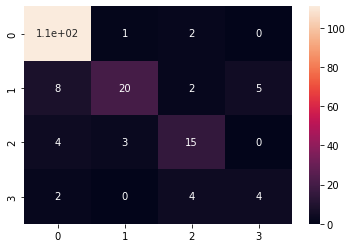

In [23]:
sns.heatmap(cm, annot=True)

<AxesSubplot:>

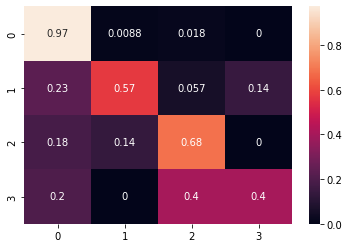

In [24]:
sns.heatmap(cm / np.tile(np.sum(cm, axis=1), (4, 1)).T, annot=True)

### Average performance

In [25]:
from sklearn.metrics import f1_score

In [26]:
num_trial = 20
f1s = []

for i in range(num_trial):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='micro')
    f1s.append(f1)

print("mean:", np.mean(f1s))
print("std :", np.std(f1s))

mean: 0.8508287292817679
std : 0.02297970645644795


## SVM

## Attention